# Make Mock Data Vector

under construction

## Mass-Observable Relation

Find a common fit between Constanzi HOD and log-normal mass observable relation

In [1]:
import numpy as np

# https://github.com/hywu/cluster-lensing-cov/blob/3630582e5ed0df0d3ae29d4988cc788bf0ff226d/clens/util/scaling_relation.py#LL29C1-L41C34
class FiducialScalingRelation(object):
    def __init__(self, nuisance):
        self.lgM0 = nuisance.lgM0
        self.alpha_M = nuisance.alpha_M
        self.lambda0 = nuisance.lambda0
        self.sigma_lambda = nuisance.sigma_lambda
        self.pars = nuisance

    def lnlambda_lnM(self, lnM):
        M = np.exp(lnM)
        return np.log(self.lambda0 * (M/10**self.lgM0)**self.alpha_M)

    def scatter(self, lnM):
        return np.sqrt(self.sigma_lambda**2 + 1/np.exp(self.lnlambda_lnM(lnM)))

class CostanziScalingRelation(object):
    """DES Y1 Cluster Cosmological MOR
    https://arxiv.org/pdf/2002.11124.pdf
    
    Table 3
    --------------------------------
    \alpha       = 0.748 ± 0.045
    \logMmin     = 11.13 ± 0.18
    \logM1       = 12.37 ± 0.11
    \sigma_intr  = < 0.325
    --------------------------------
    """
    def __init__(self, nuisance):
        self.alpha_M = nuisance.alpha_M
        self.Mmin = 10**nuisance.logMmin
        self.M1 = 10**nuisance.logM1        
        self.sigma_lambda = nuisance.sigma_lambda
        self.pars = nuisance

    def lnlambda_lnM(self, lnM):
        M = np.exp(lnM)
        lbd_sat = np.power( (M-self.Mmin)/(self.M1-self.Mmin), self.alpha_M)
        return np.log(lbd_sat+1.)

    def scatter(self, lnM):
        return np.sqrt(self.sigma_lambda**2 + 1/np.exp(self.lnlambda_lnM(lnM)))
    


### Set Default Values

Here you set the default values of the scaling relations

In [32]:
class NuisanceParameters(dict):
    def __init__(self, defaultNuisanceParameters, **pardict):
        super(NuisanceParameters, self).__init__(defaultNuisanceParameters) # set to default value
        for k in pardict:
            if k in self:
                self[k] = pardict[k]
            

    def __getattr__(self, attr):
        return self[attr]

    def __str__(self):
        r = 'parameters:\n'
        for k in self:
            r += "\t-> %s = %s\n" % (k, str(self[k]))
        return r[:-1]
    
fiducialNuisanceParameters = {
    "lgM0": 14.6258, #log10(3e14/h) # Costanzi 21
    "alpha_M": 1,
    "lambda0": 70,
    "sigma_lambda": 0.18
}

costanziNuisanceParameters = {
    "logMmin": 11.13, #log10(3e14/h) # Costanzi 21
    "alpha_M": 0.75,
    "logM1": 12.37,
    "sigma_lambda": 0.18
}


In [33]:
cParams = NuisanceParameters(costanziNuisanceParameters)
print(cParams.__str__())

parameters:
	-> logMmin = 11.13
	-> alpha_M = 0.75
	-> logM1 = 12.37
	-> sigma_lambda = 0.18


In [34]:
fParams = NuisanceParameters(fiducialNuisanceParameters)
print(fParams.__str__())

parameters:
	-> lgM0 = 14.6258
	-> alpha_M = 1
	-> lambda0 = 70
	-> sigma_lambda = 0.18


## Check MOR values

In [35]:
fMOR = FiducialScalingRelation(fParams)
print('--- Check Lambda Values ---')
print('M200=1e14, lambda=%.2f'%(np.exp(fMOR.lnlambda_lnM(np.log(1e14)))))
print('M200=1e15, lambda=%.2f'%(np.exp(fMOR.lnlambda_lnM(np.log(1e15)))))

--- Check Lambda Values ---
M200=1e14, lambda=16.57
M200=1e15, lambda=165.69


In [36]:
cMOR = CostanziScalingRelation(cParams)
print('--- Check Lambda Values ---')
print('M200=1e14, lambda=%.2f'%(np.exp(cMOR.lnlambda_lnM(np.log(1e14)))))
print('M200=1e15, lambda=%.2f'%(np.exp(cMOR.lnlambda_lnM(np.log(1e15)))))

--- Check Lambda Values ---
M200=1e14, lambda=18.43
M200=1e15, lambda=99.12


## Translate Log-Normal params to HOD mass-observable relation

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('talk')

In [38]:
mvec = np.logspace(13.5,15.3,500)
log_lbd_true = fMOR.lnlambda_lnM(np.log(mvec))
lbdvec = np.exp(log_lbd_true + fMOR.scatter(np.log(mvec))*np.random.normal(size=mvec.size))

In [39]:
# fit the hod model


Text(0, 0.5, '$\\lambda$')

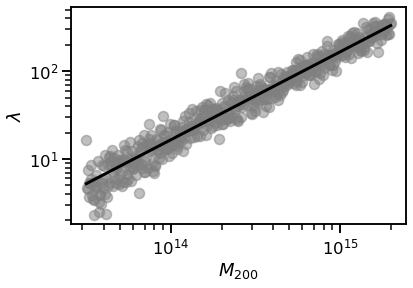

In [40]:
plt.loglog()
plt.plot(mvec,np.exp(log_lbd_true),color='k',lw=3,label='log-normal')
plt.scatter(mvec,lbdvec,color='gray',s=100,alpha=0.5)
plt.xlabel(r'$M_{200}$')
plt.ylabel(r'$\lambda$')

In [41]:
# fitCostanziScalingRelation(np.log(mvec),0.8,11.,12.)
def _fitCostanziScalingRelation(alpha,logMin,logM1):
    mypars = {"logMmin": logMin, 
             "alpha_M": alpha,
             "logM1": logM1,
             "sigma_lambda": 0.18
           }
    pars = NuisanceParameters(mypars)
    return CostanziScalingRelation(pars)

def fitCostanziScalingRelation(x,alpha,logMin,logM1):
    toBeFitted = _fitCostanziScalingRelation(alpha,logMin,logM1)
    return toBeFitted.lnlambda_lnM(x)

In [42]:
from scipy.optimize import curve_fit
popt, pcov = curve_fit(fitCostanziScalingRelation, np.log(mvec), np.log(lbdvec), p0=[0.75,11.13,12.37])
perr = np.sqrt(np.diag(pcov)) # errors

/tmp/ipykernel_53179/3641283992.py:40: RuntimeWarning: invalid value encountered in power
  lbd_sat = np.power( (M-self.Mmin)/(self.M1-self.Mmin), self.alpha_M)


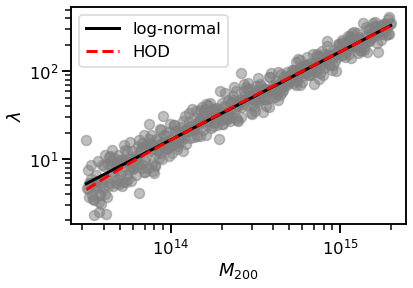

In [43]:
bestFit = _fitCostanziScalingRelation(*popt)
ypred = np.exp(bestFit.lnlambda_lnM(np.log(mvec)))

plt.loglog()
plt.plot(mvec, np.exp(log_lbd_true),color='k',lw=3,label='log-normal')
plt.plot(mvec, ypred, color='r', lw=3, ls='--', label='HOD')
plt.scatter(mvec,lbdvec,color='gray',s=100,alpha=0.5)

plt.xlabel(r'$M_{200}$')
plt.ylabel(r'$\lambda$')
plt.legend()

In [44]:
print(bestFit.pars)

parameters:
	-> logMmin = 13.108386280696779
	-> alpha_M = 0.9757536356109173
	-> logM1 = 13.257425483455542
	-> sigma_lambda = 0.18


In [46]:
print(fMOR.pars)

parameters:
	-> lgM0 = 14.6258
	-> alpha_M = 1
	-> lambda0 = 70
	-> sigma_lambda = 0.18


## Translate HOD mass-observable relation to Log-Normal params

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('talk')

In [48]:
mvec = np.logspace(13.5,15.3,500)
log_lbd_true = cMOR.lnlambda_lnM(np.log(mvec))
lbdvec = np.exp(log_lbd_true + cMOR.scatter(np.log(mvec))*np.random.normal(size=mvec.size))

Text(0, 0.5, '$\\lambda$')

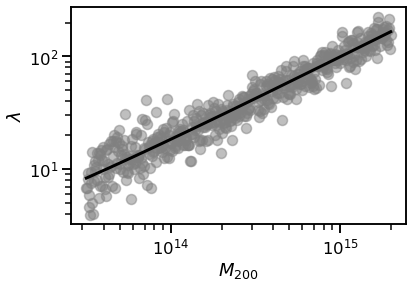

In [49]:
plt.loglog()
plt.plot(mvec,np.exp(log_lbd_true),color='k',lw=3,label='HOD')
plt.scatter(mvec,lbdvec,color='gray',s=100,alpha=0.5)
plt.xlabel(r'$M_{200}$')
plt.ylabel(r'$\lambda$')

In [53]:
# fitCostanziScalingRelation(np.log(mvec),0.8,11.,12.)
def _fitLogNormalRelation(alpha, lgM0, lambda0):
    mypars = {
              "lgM0": lgM0, #log10(3e14/h) # Costanzi 21
              "alpha_M": alpha,
              "lambda0": lambda0,
              "sigma_lambda": 0.18}
    pars = NuisanceParameters(mypars)
    return FiducialScalingRelation(pars)

def fitLogNormalRelation(x, alpha, lgM0, lambda0):
    toBeFitted = _fitLogNormalRelation(alpha, lgM0, lambda0)
    return toBeFitted.lnlambda_lnM(x)

In [55]:
from scipy.optimize import curve_fit
popt, pcov = curve_fit(fitLogNormalRelation, np.log(mvec), np.log(lbdvec), p0=[0.75,14.75260301, 64.50384939])
perr = np.sqrt(np.diag(pcov)) # errors
popt

/tmp/ipykernel_53179/3641283992.py:14: RuntimeWarning: divide by zero encountered in true_divide
  return np.log(self.lambda0 * (M/10**self.lgM0)**self.alpha_M)
/tmp/ipykernel_53179/3641283992.py:14: RuntimeWarning: invalid value encountered in log
  return np.log(self.lambda0 * (M/10**self.lgM0)**self.alpha_M)


array([ 0.71616806, 14.70391692, 59.52726729])

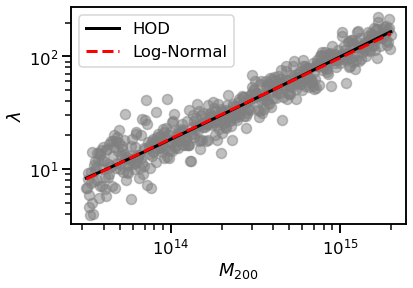

In [56]:
bestFit = _fitLogNormalRelation(*popt)
ypred = np.exp(bestFit.lnlambda_lnM(np.log(mvec)))

plt.loglog()
plt.plot(mvec,np.exp(log_lbd_true),color='k',lw=3,label='HOD')
plt.plot(mvec, ypred, color='r', lw=3, ls='--', label='Log-Normal')
plt.scatter(mvec,lbdvec,color='gray',s=100,alpha=0.5)

plt.xlabel(r'$M_{200}$')
plt.ylabel(r'$\lambda$')
plt.legend()

In [57]:
print(bestFit.pars)

parameters:
	-> lgM0 = 14.703916921102891
	-> alpha_M = 0.7161680569436991
	-> lambda0 = 59.52726729416352
	-> sigma_lambda = 0.18


In [59]:
print(cMOR.pars)

parameters:
	-> logMmin = 11.13
	-> alpha_M = 0.75
	-> logM1 = 12.37
	-> sigma_lambda = 0.18


In [61]:
10**12.37

2344228815319.918

In [58]:
bestFit.pars

{'lgM0': 14.703916921102891,
 'alpha_M': 0.7161680569436991,
 'lambda0': 59.52726729416352,
 'sigma_lambda': 0.18}

## Mixture Model Scaling Relation



In [134]:
class MixtureScalingRelation(object):
    def __init__(self, nuisance):
        # pivot mass
        self.lgM0 = nuisance.lgM0
        
        # first component
        self.alpha_M = nuisance.alpha_M
        self.lambda0 = nuisance.lambda0
        self.sigma_lambda1 = nuisance.sigma_lambda
        
        # second component
        # same slope
        # same intercept
        self.q = nuisance.q  # x ln(M/M0)
        
        # weight
        self.w = nuisance.weight
        
        self.pars = nuisance

    def lnlambda_lnM(self, lnM):
        # valid for the first component
        M = np.exp(lnM)
        return np.log(self.lambda0 * (M/10**self.lgM0)**self.alpha_M)
    
    def simulatedLambda(self, lnM):
        n1 = int(self.w*lnM.size)
        n2 = int((1-self.w)*lnM.size)
        ix1 = np.random.randint(lnM.size, size=n1)
        ix2 = np.random.randint(lnM.size, size=n2)
        
        _y1 = self.lnlambda_lnM(lnM[ix1])
        _y2 = self.lnlambda_lnM(lnM[ix2])
        
        y1 = _y1 + self.scatter1(lnM[ix1]) * np.random.normal(size=n1)
        y2 = _y2 + self.scatter2(lnM[ix2]) * np.random.normal(size=n2)
        
        m = np.append(lnM[ix1],lnM[ix2])
        y = np.append(y1, y2)
        mask = np.full((m.size,), False)
        mask[np.arange(y1.size, dtype=int)] = True
        return m, y, mask
        
    def scatter1(self, lnM):
        return self.sigma_lambda1

    def scatter2(self, lnM):
        return self.sigma_lambda1 + self.q *(lnM-np.log(10**self.lgM0))

MixtureParameters = {
    "lgM0": 14.6258, #log10(3e14/h) # Costanzi 21
    "alpha_M": 1,
    "lambda0": 70,
    "sigma_lambda": 0.18,
    "q":-0.25,
    "weight":0.8
}

In [135]:
from colossus.cosmology import cosmology
cosmology.setCosmology('planck18');

In [136]:
from colossus.lss import mass_function
z = 0.4
mfunc = mass_function.massFunction(mvec, z, mdef = '200c', model = 'tinker08', q_out = 'dndlnM')

In [137]:
prob = mfunc/np.sum(mfunc)
idx = np.random.choice(len(mvec),size=len(mvec),p=prob)
msims = mvec[idx]

In [138]:
mParams = NuisanceParameters(MixtureParameters)
mMOR = MixtureScalingRelation(mParams)

In [139]:
m, y, c = mMOR.simulatedLambda(np.log(msims))

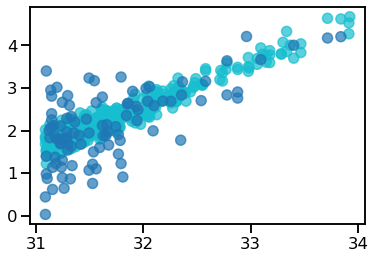

In [149]:
plt.scatter(m, y, c=c, cmap='tab10', alpha=0.7, s=100)

In [43]:
# help(np.in1d)

In [39]:
10**13.184319568561333*1e-13

1.528690506636719

In [40]:
10**12.998058115732233*1e-13

0.9955386278523171

In [41]:
lbd_bins = np.array([20.0,30.0,45.0,60.0,1000])

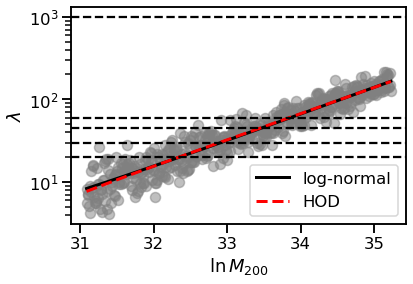

In [42]:
bestFit = _fitCostanziScalingRelation(*popt)
ypred = np.exp(bestFit.lnlambda_lnM(np.log(mvec)))

plt.yscale('log')
plt.plot(np.log(mvec), np.exp(log_lbd_true),color='k',lw=3,label='log-normal')
plt.plot(np.log(mvec), ypred, color='r', lw=3, ls='--', label='HOD')
plt.scatter(np.log(mvec), lbdvec,color='gray',s=100,alpha=0.5)
for lbd in lbd_bins:
    plt.axhline(lbd, color='k',ls='--')

plt.xlabel(r'$\ln M_{200}$')
plt.ylabel(r'$\lambda$')
plt.legend()

In [149]:
bestFit.lnlambda_lnM(30.0)

/tmp/ipykernel_170073/2893860831.py:40: RuntimeWarning: invalid value encountered in power
  lbd_sat = np.power( (M-self.Mmin)/(self.M1-self.Mmin), self.alpha_M)


nan

In [20]:
np.log10(np.exp(38.0))

16.503190312323568

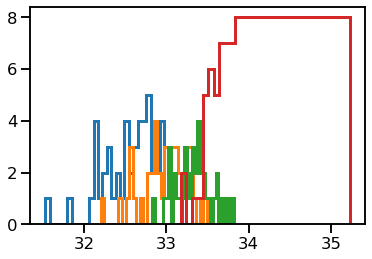

In [21]:
## probabilities
lbd_low = lbd_bins[:-1]
lbd_high= lbd_bins[1:]

for lbd_min, lbd_max in zip(lbd_low, lbd_high):
    w, = np.where( (lbdvec>lbd_min)&(lbdvec<=lbd_max) )
    plt.hist(np.log(mvec[w]), bins=31, histtype='step',lw=3)

## Find New Lambda Binning

In [23]:
from colossus.cosmology import cosmology
cosmology.setCosmology('planck18');

In [129]:
from colossus.lss import mass_function
z = 0.4
M = 10**np.arange(14.0, 15.1, 0.025)
mfunc = mass_function.massFunction(M, z, mdef = '200c', model = 'tinker08', q_out = 'dndlnM')

In [130]:
from scipy.interpolate import interp1d
cummfunc = np.cumsum(mfunc)
cummfunc = (cummfunc-np.min(cummfunc))/(np.max(cummfunc)-np.min(cummfunc))
massbins = np.exp(interp1d(cummfunc, np.log(M),fill_value='extrapolate')([0.0,0.30,0.5,0.75,0.90,1.0]))
massbins

array([1.00000000e+14, 1.19588763e+14, 1.40327910e+14, 1.90393948e+14,
       2.72457085e+14, 1.18850223e+15])

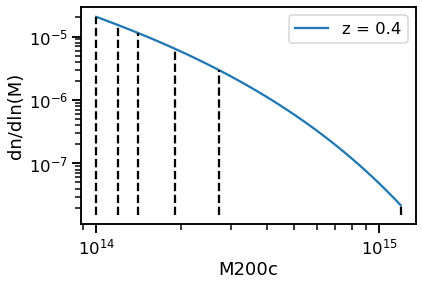

In [131]:
plt.figure()
plt.xlabel('M200c')
plt.ylabel('dn/dln(M)')
plt.loglog()
plt.plot(M, mfunc, '-', label = 'z = %.1f' % (z))

xmin, xmax = plt.gca().get_xlim()
ymin, ymax = plt.gca().get_ylim()
for mb in massbins:
    plt.plot([mb, mb], [ymin, np.interp(mb, M,mfunc)], ls='--', color='k')
plt.legend();

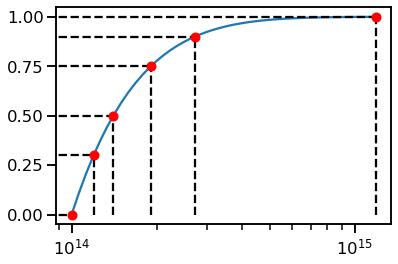

In [132]:
plt.xscale('log')
plt.plot(M,cummfunc)
for mb in massbins:
    plt.plot([mb, mb], [ymin, np.interp(mb, M,cummfunc)], ls='--', color='k')
    plt.plot([0, mb], [np.interp(mb, M,cummfunc), np.interp(mb, M,cummfunc)], ls='--', color='k')
    plt.plot([mb], [np.interp(mb, M,cummfunc)], 'ro')
_ = plt.yticks(np.linspace(0,1.,5))

In [133]:
lbdbins = np.exp(bestFit.lnlambda_lnM(np.log(massbins)))
lbdbins

array([ 16.74789424,  20.16965351,  23.76948295,  32.38432436,
        46.33678206, 196.39894967])

In [134]:
mnew = M[np.random.choice(M.size, p=mfunc/np.sum(mfunc),size=50000)]
log_lbd_true = bestFit.lnlambda_lnM(np.log(mnew))
lbdnew = np.exp(log_lbd_true + fMOR.scatter(np.log(mnew))*np.random.normal(size=mnew.size))

In [140]:
ix = np.argsort(lbdnew)
cummfunc = np.cumsum(lbdnew[ix])
cummfunc = (cummfunc-np.min(cummfunc))/(np.max(cummfunc)-np.min(cummfunc))
lbdbins = np.exp(interp1d(cummfunc, np.log(lbdnew[ix]),fill_value='extrapolate')(np.linspace(0,1.,6)))
lbdbins

array([  5.70957062,  21.04566755,  27.86234427,  36.91303573,
        54.24700545, 302.75249428])

21.045667551425307 27.86234426840987
27.86234426840987 36.913035731844644
36.913035731844644 54.24700545451638
54.24700545451638 302.7524942772902


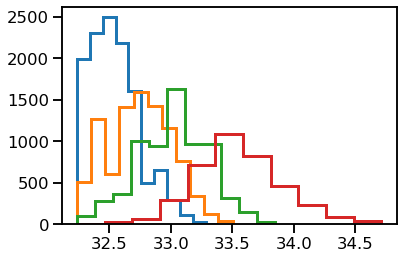

In [143]:
## probabilities
lbd_low = lbdbins[:-1]
lbd_high= lbdbins[1:]

for lbd_min, lbd_max in zip(lbd_low[1:], lbd_high[1:]):
    print(lbd_min, lbd_max)
    w, = np.where( (lbdnew>lbd_min)&(lbdnew<=lbd_max) )
    plt.hist(np.log(mnew[w]), bins=11, histtype='step',lw=3)

In [142]:
np.round(lbdbins, 0)

array([  6.,  21.,  28.,  37.,  54., 303.])